<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports and Plot Stylizations

In [9]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

In [10]:

def getStockData(ticker: str, startYear: str, endYear: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=5y&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
  return datetime.fromtimestamp(t)


# Plotting AAPL close prices to visualize

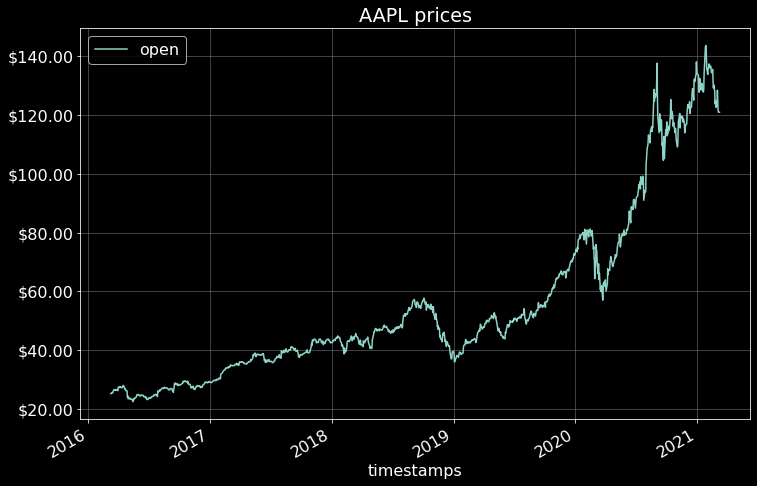

In [11]:
ticker = 'AAPL'
df = getStockData(ticker, "2017", "2020")

ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method for labeling price data as BUY, HOLD, or SELL

*SELL = 0, BUY = 1, HOLD = 2*


*Parameters:*

    df: Pandas DataFrame
    col_name: Name of the column in df that will be used to determine labels
        - availiable names: "open", "close", "high", "low"
    window_size: How large the window size will be when determining labels
        - default size: 11

In [12]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)

    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column

In [13]:
labels = create_labels(df, 'close')
df['labels'] = labels
df['labels'] = df['labels'].fillna(0)

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')

TypeError: ignored

# Technical Indicator methods


***Technical Indicators Used:***

*   MACD
*   RSI
*   %K
*   %D
*   ATR
*   DEMA
*   BB
*   WR









In [ ]:
# MACD: Moving Average Convergance Diverage Momentum
def calculate_macd(df):
    # MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
    # The speed of crossovers is also taken as a signal of a market is overbought or oversold.
    # MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.
    df['MACD'] = df["close"].ewm(span=12).mean() - df["close"].ewm(span=26).mean()
    df['MACD'] = df['MACD'].fillna(0)
    #df['Signal Line'] = df['MACD'].ewm(span=9).mean()


# RSI: Relative Strength Index 
def calculate_rsi(df):
    # Signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset's price
    # An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%
    # A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset
    # The RSI is displayed as an oscillator and can have a reading from 0 to 100.
    diff = df['close'].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    down = abs(down)
    elevenDayUpCloses = up.rolling(11).mean() # using 11 day periods
    elevenDayDownCloses = down.rolling(11).mean() # using 11 day periods
    relative_strength = elevenDayUpCloses / elevenDayDownCloses
    df['RSI'] = 100 - (100/(1+relative_strength))
    df['RSI'] = df['RSI'].fillna(0)

# SR: Stochastic Oscillator
def calculate_sr(df):
    # The general theory serving as the foundation for this indicator is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low
    # Transaction signals are created when the %K crosses through a three-period moving average, which is called the %D.
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    # %K is referred to sometimes as the fast stochastic indicator
    fast_K = (df['close']-eleven_low)*100/(eleven_high - eleven_low)
    # The "slow" stochastic indicator is taken as %D = 3-period moving average of %K
    df['%D'] = fast_K.rolling(3).mean()
    df['%D'] = df['%D'].fillna(0)

# WR: Williams %R Indicator
def calculate_WR(df):
    # Williams %R moves between zero and -100.
    # A reading above -20 is overbought.
    # A reading below -80 is oversold.
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    df['WR'] = (eleven_high - df['close']) / (eleven_high - eleven_low) * -100
    df['WR'] = df['WR'].rolling(3).mean()
    df['WR'] = df['WR'].fillna(0)
   
# EMA: Exponential Moving Average
def calculate_ema(df):
    # Moving average that places a greater weight and significance on the most recent data points
    # Traders often use several different EMA lengths, such as 10-day, 50-day, and 200-day moving averages.
    multiplier = (2/(11+1))
    ema_1 = sum(df['close'],11)
    df['EMA'] = (df['close'] -  ema_1) * ema_1 + multiplier # -> Is this right?
    df['EMA'] = df['EMA'].fillna(0)
    return df['EMA']


# MFI: Money Flow Index
def calculate_mfi(df):
    price = (df['close'] + df['high'] + df['low']) / 3
    #mf = df['tp'] * df['volume']
    mf = price * df['volume']
    positive_flow = []
    negative_flow = []
    positive_mf = []
    negative_mf = []
    # Loop through typical price calculations
    for i in range(1, len(price)):
        if price[i] > price[i-1]:
            positive_flow.append(mf[i-1])
            negative_flow.append(0)
        elif price[i] < [i-1]:
            negative_flow.append(mf[i-1])
            positive_flow.append(0)
        else:
            positive_flow.append(0)
            negative_flow.append(0) 
    for i in range(len(positive_flow) + 1):
        positive_mf.append(sum(positive_flow[i+1-11:i+1]))
    for i in range(len(negative_flow) + 1):
        negative_mf.append(sum(negative_flow[i+1-11:i+1]))
    df['MFI'] = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    df['MFI'] = df['MFI'].fillna(0)


# BB: Bollinger Band
def calculate_bb(df):
    # When the bands come close together, constricting the moving average, it is called a squeeze.
    # The mistake most people make is believing that that price hitting or exceeding one of the bands is a signal to buy or sell. 
    # Breakouts provide no clue as to the direction and extent of future price movement.
    # Creating temporary Dataframe
    atr_df = pd.DataFrame()
    atr_df['close'] = df['close']
    atr_df['MA11'] = df['close'].rolling(window=11).mean()
    atr_df['11STD'] = df['close'].rolling(window=11).std()
    atr_df['Upper'] = atr_df['MA11'] + (atr_df['11STD'] * 2) # -> Where is this 2 coming from?
    atr_df['Lower'] = atr_df['MA11'] - (atr_df['11STD'] * 2)
    df['BB'] = atr_df[['close','MA11','Upper','Lower']].max(axis=1)
    df['BB'] = df['BB'].fillna(0)
    # return df['BB']

# ATR: Average True Range
def calculate_atr(df):
    data = df.copy()
    high = df['high']
    low = df['low']
    close = df['close']
    tr_0 = abs(high - low)
    # Creating temporary Dataframe
    atr_df = pd.DataFrame()
    atr_df['tr0'] = abs(high - low)
    atr_df['tr1'] = abs(high - close.shift())
    atr_df['tr2'] = abs(low - close.shift())
    atr_df['TR'] = atr_df[['tr0', 'tr1', 'tr2']].max(axis=1)
    df['ATR'] = atr_df['TR'].ewm(alpha=1/11,adjust=False).mean()
    df['ATR'] = df['ATR'].fillna(0)
    print(np.where(df['ATR'] < 0))
    return df['ATR']

# KC: Kelter Channel
def calculate_kc(df):
    #df['KC'] = df.copy
    #KelChM = pd.Series(((df['high'] + df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChM_' + str(11)) 
    #KelChU = pd.Series(((4 * df['high'] - 2 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChU_' + str(11))  
    #KelChD = pd.Series(((-2 * df['high'] + 4 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChD_' + str(11))
    atr = calculate_atr(df)
    temp_df = pd.DataFrame()
    temp_df['middle'] = calculate_ema(df)
    temp_df['upper'] = temp_df['middle'] + 2 * atr
    temp_df['lower'] = temp_df['middle'] - 2 * atr
    df['KC'] = temp_df[['middle','upper','lower']].max(axis=1)
    df['KC'] = df['KC'].fillna(0)
    #print(np.where(temp_df['middle'] > temp_df['upper']))


# DEMA: Double Exponential Moving Average
def calculate_dema(df):
    multiplier = (2/(11+1))
    dema_1 = sum(df['close'],11)
    df['DEMA'] = (df['close'] * multiplier) + (dema_1 * (1-multiplier))
    df['DEMA'] = df['DEMA'].fillna(0)


# CCI: Commodity Channel Index
def calculate_cci(df):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    df['CCI'] = ((typical_price - typical_price.rolling(11).mean())/ (0.015 * typical_price.rolling(11).std()))
    df['CCI'] = df['CCI'].fillna(0)


# EMV: Ease of Movement Volume
def calculate_emv(df):
    distance_moved = ((df['high'] + df['low'])/2) - ((df['high'].shift(1) + df['low'].shift(1))/2)
    box_ratio = (df['volume'] / 100000000) / ((df['high'] - df['low']))
    df['EVM'] = distance_moved / box_ratio 
    df['EVM'] = df['EVM'].fillna(0)


# FI: Force Index
def calculate_fi(df, iteration):
    df['FI_'+str(iteration)] = df['close'].diff(11) * df['volume']
    df['FI_'+str(iteration)] = df['FI_'+str(iteration)].fillna(0)


# ROC: Price Rate of Change
def calculate_roc(df, iteration):
    N = df['close'].diff(11)
    D = df['close'].shift(11)
    df['ROC_'+str(iteration)] = N / D
    df['ROC_'+str(iteration)] = df['ROC_'+str(iteration)].fillna(0)


# OBV: On-Balance Volume
def calculate_obv(df, iteration):
    df['OBV_'+str(iteration)] = np.where(df['close'] > df['close'].shift(1), df['volume'], np.where(df['close'] < df['close'].shift(1), -df['volume'],0)).cumsum()
    df['OBV_'+str(iteration)] = df['OBV_'+str(iteration)].fillna(0)

In [ ]:
#calculate_kc(df)

# Run all Technical Indicator methods

In [ ]:
range = 3

calculate_macd(df)
calculate_rsi(df)
calculate_sr(df)
calculate_WR(df)
calculate_ema(df)
calculate_mfi(df)
calculate_bb(df)
calculate_atr(df)
calculate_kc(df)
calculate_dema(df)
calculate_cci(df)
calculate_emv(df)

for x in range(1, range+1):
    calculate_fi(df, x)
for x in range(1, range+1):
    calculate_roc(df, x)
for x in range(1, range+1):
    calculate_obv(df, x)

# Plot charts for Technical Indicators

In [ ]:
def plot_indicators(df, columns, yTitle, xTitle):
    plt.figure()
    ax = df[columns].plot(title=yTitle)
    ax.set_xlabel(xTitle)
    ax.set_ylabel(yTitle)

plot_indicators(df, ['MACD'], "MACD", "Days")
plot_indicators(df, "RSI", "RSI", "Days")

# Normalization of the Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

pd.options.display.max_columns = 20

print(df.columns)
list_features = list(df.loc[:, 'MACD': 'OBV'].columns) # Gets the names of all the columns from MACD to RSI
print('Total number of features', len(list_features))
print("Columns:", list_features)


# df.loc[:, 'MACD':'RSI'].values: -> Data used to create 'x_train' and 'x_test'
# df['labels'].values: -> Data used to create 'y_train' and 'y_test'
print(df.loc[:, 'MACD':'OBV'])
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'MACD':'OBV'].values, df['labels'].values, train_size=0.8, test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

if 0.7*x_train.shape[0] < 2500:
    # If training dataset is small, it increases the percentage of training
    train_split = 0.8
else:
    train_split = 0.7

print('train_split =', train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)

mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
#print(x_train[0])
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


# Feature Selection

In [ ]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

num_features = 225  # should be a perfect square
selection_method = 'all'
topk = 225 if selection_method == 'all' else num_features

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")

if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)  # x_train[:, feat_idx] will give you training data with desired features

# Reshaping the Data as an Image

In [ ]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))